16.3.22

# Follow up analysis of cutaneous vs. mucosal. 
The analysis that was presented to Keren and Moshe (24.1.22).

1. in myeloid sub-clustering, cells in siglec10 cluster should express CD52. check correlation between CD52 and SIGLEC10 cluster.
2. correlation between clusters & GEPs (samples fractions).
3. CNV patterns, let's see whether we can see some differences between Cutaneous/Mucosal samples' CNV patterns.
4. remove GEP #14, suspected to be an immune cluster. first validate then plan execute removal. 
5. Create new cohort and new cohort without contaminated cells (found in clause 4). Repeat all analysis here above.

In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
import scipy.stats as stats
import warnings 
warnings.filterwarnings("ignore")

## 1. Myeloid sub-clustering - cells in siglec10+ cluster should express CD52. check correlation between CD52 and SIGLEC10 cluster.

In [2]:
myeloid_annotation_path = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/subcohort_1.1.22/17.1.22/Myeloid.xlsx'
MYELOID_CLUSTER_BARCODE_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/subcohort_1.1.22_run_1.1.22/subcohort_myeloid_1.1.22_clusters_mapping.csv'
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/subcohort/normalized/1.1.22/subcohort_normalized_1.1.22_protein_coding_genes.pkl'

cohort = pickle.load(open(COHORT_PATH, 'rb'))

In [3]:
clusters_barcodes_mapping_df = pd.read_csv(MYELOID_CLUSTER_BARCODE_MAPPING_PATH)[['Sample', 'Barcode', 'Cluster']]
myeloid_ann = pd.read_excel(myeloid_annotation_path)

cluster_idx = myeloid_ann[myeloid_ann['annotation']=='SIGLEC10+'].iloc[0].cluster

pos_siglec10_cluster_df = clusters_barcodes_mapping_df[clusters_barcodes_mapping_df['Cluster']==cluster_idx]
neg_siglec10_cluster_df = clusters_barcodes_mapping_df[clusters_barcodes_mapping_df['Cluster']!=cluster_idx]

In [4]:
pos_siglec10_cohort = cohort.get_subset_by_identifiers(pos_siglec10_cluster_df.Sample, pos_siglec10_cluster_df.Barcode)
neg_siglec10_cohort = cohort.get_subset_by_identifiers(neg_siglec10_cluster_df.Sample, neg_siglec10_cluster_df.Barcode)

pos_siglec10_expression = pos_siglec10_cohort.counts[:,cohort.gene_names.index('CD52')]
neg_siglec10_expression = neg_siglec10_cohort.counts[:,cohort.gene_names.index('CD52')]

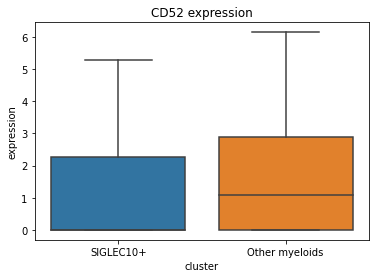

In [5]:
sns.reset_orig() # reset size of figure
# sns.histplot(pos_soglec10_expression).set(title='CD52 expression in siglec10+ cluster');
pos_df = pd.DataFrame(pos_siglec10_expression, columns=['expression'])
pos_df['cluster']=  'SIGLEC10+'
neg_df = pd.DataFrame(neg_siglec10_expression, columns=['expression'])
neg_df['cluster']= 'Other myeloids'
sns.boxplot(x='cluster', y='expression', data=pos_df.append(neg_df)).set(title='CD52 expression');


Percentage of cells in cluster expressing CD52:

In [6]:
expressing_threshold = 1
print(f'SIGLEC10+ % cells expressing CD52: {sum(pos_siglec10_expression>expressing_threshold)/len(pos_siglec10_expression)}')
print(f'Other clusters % cells expressing CD52: {sum(neg_siglec10_expression>expressing_threshold)/len(neg_siglec10_expression)}')

SIGLEC10+ % cells expressing CD52: 0.46883468834688347
Other clusters % cells expressing CD52: 0.5064427392500362


## 2. correlation between clusters & GEPs (samples fractions).

Extract GEP fraction df:

In [72]:
melanoma_clinical_data = get_constant_cohort(3) #get_clinical_data(71)#ICI=True, after_biopsy='ICI')
# melanoma_clinical_data

GEP_DF, R_GEP_DF, NR_GEP_DF = get_GEP_dfs(melanoma_clinical_data, EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/subcohort_1.1.22',
                    RUN_RANGE = '20', selected_K=20, number_of_genes=2000, n_replicates=200, local_density_threshold='0.10', FEATURE='response', FEATURE_A='R', FEATURE_B='NR')
contaminated_cells_path = r'/storage/md_keren/shitay/Data/tables/GEP/subcohort_1.1.22/contaminated_cells_list/GEP14_contaminated_cells.csv'
GEP_DF = filter_contaminated_cells_out_of_GEP_DF(GEP_DF, 14, contaminated_cells_path = contaminated_cells_path)

GEP_fraction_df = get_GEP_fraction_df(GEP_DF)
### reform GEP_fraction_df
GEP_fraction_df = GEP_fraction_df.pivot(index='sample', columns='program')
GEP_fraction_df.columns = GEP_fraction_df.columns.droplevel(0)
# GEP_fraction_df

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_12.21_unportected.csv

and labels:
/storage/md_keren/shitay/Data/tables/clinical_labels.csv


### myeloid clusters & GEP correlation:

In [73]:
#Extract myeloid cluster fraction df:
MYELOID_CLUSTER_BARCODE_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/subcohort_1.1.22_run_1.1.22/subcohort_myeloid_1.1.22_clusters_mapping.csv'
myeloid_annotation_path = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/subcohort_1.1.22/17.1.22/Myeloid.xlsx'

myeloid_ann = pd.read_excel(myeloid_annotation_path).set_index('cluster')
mye_clusters_barcodes_mapping_df = pd.read_csv(MYELOID_CLUSTER_BARCODE_MAPPING_PATH)[['Sample', 'Barcode', 'Cluster']]

mye_cluster_fraction_df = get_cluster_fraction_df(mye_clusters_barcodes_mapping_df)
### reform cluster_fraction_df
mye_cluster_fraction_df = mye_cluster_fraction_df.pivot(index='sample', columns='cluster')
mye_cluster_fraction_df.columns = mye_cluster_fraction_df.columns.droplevel(0)

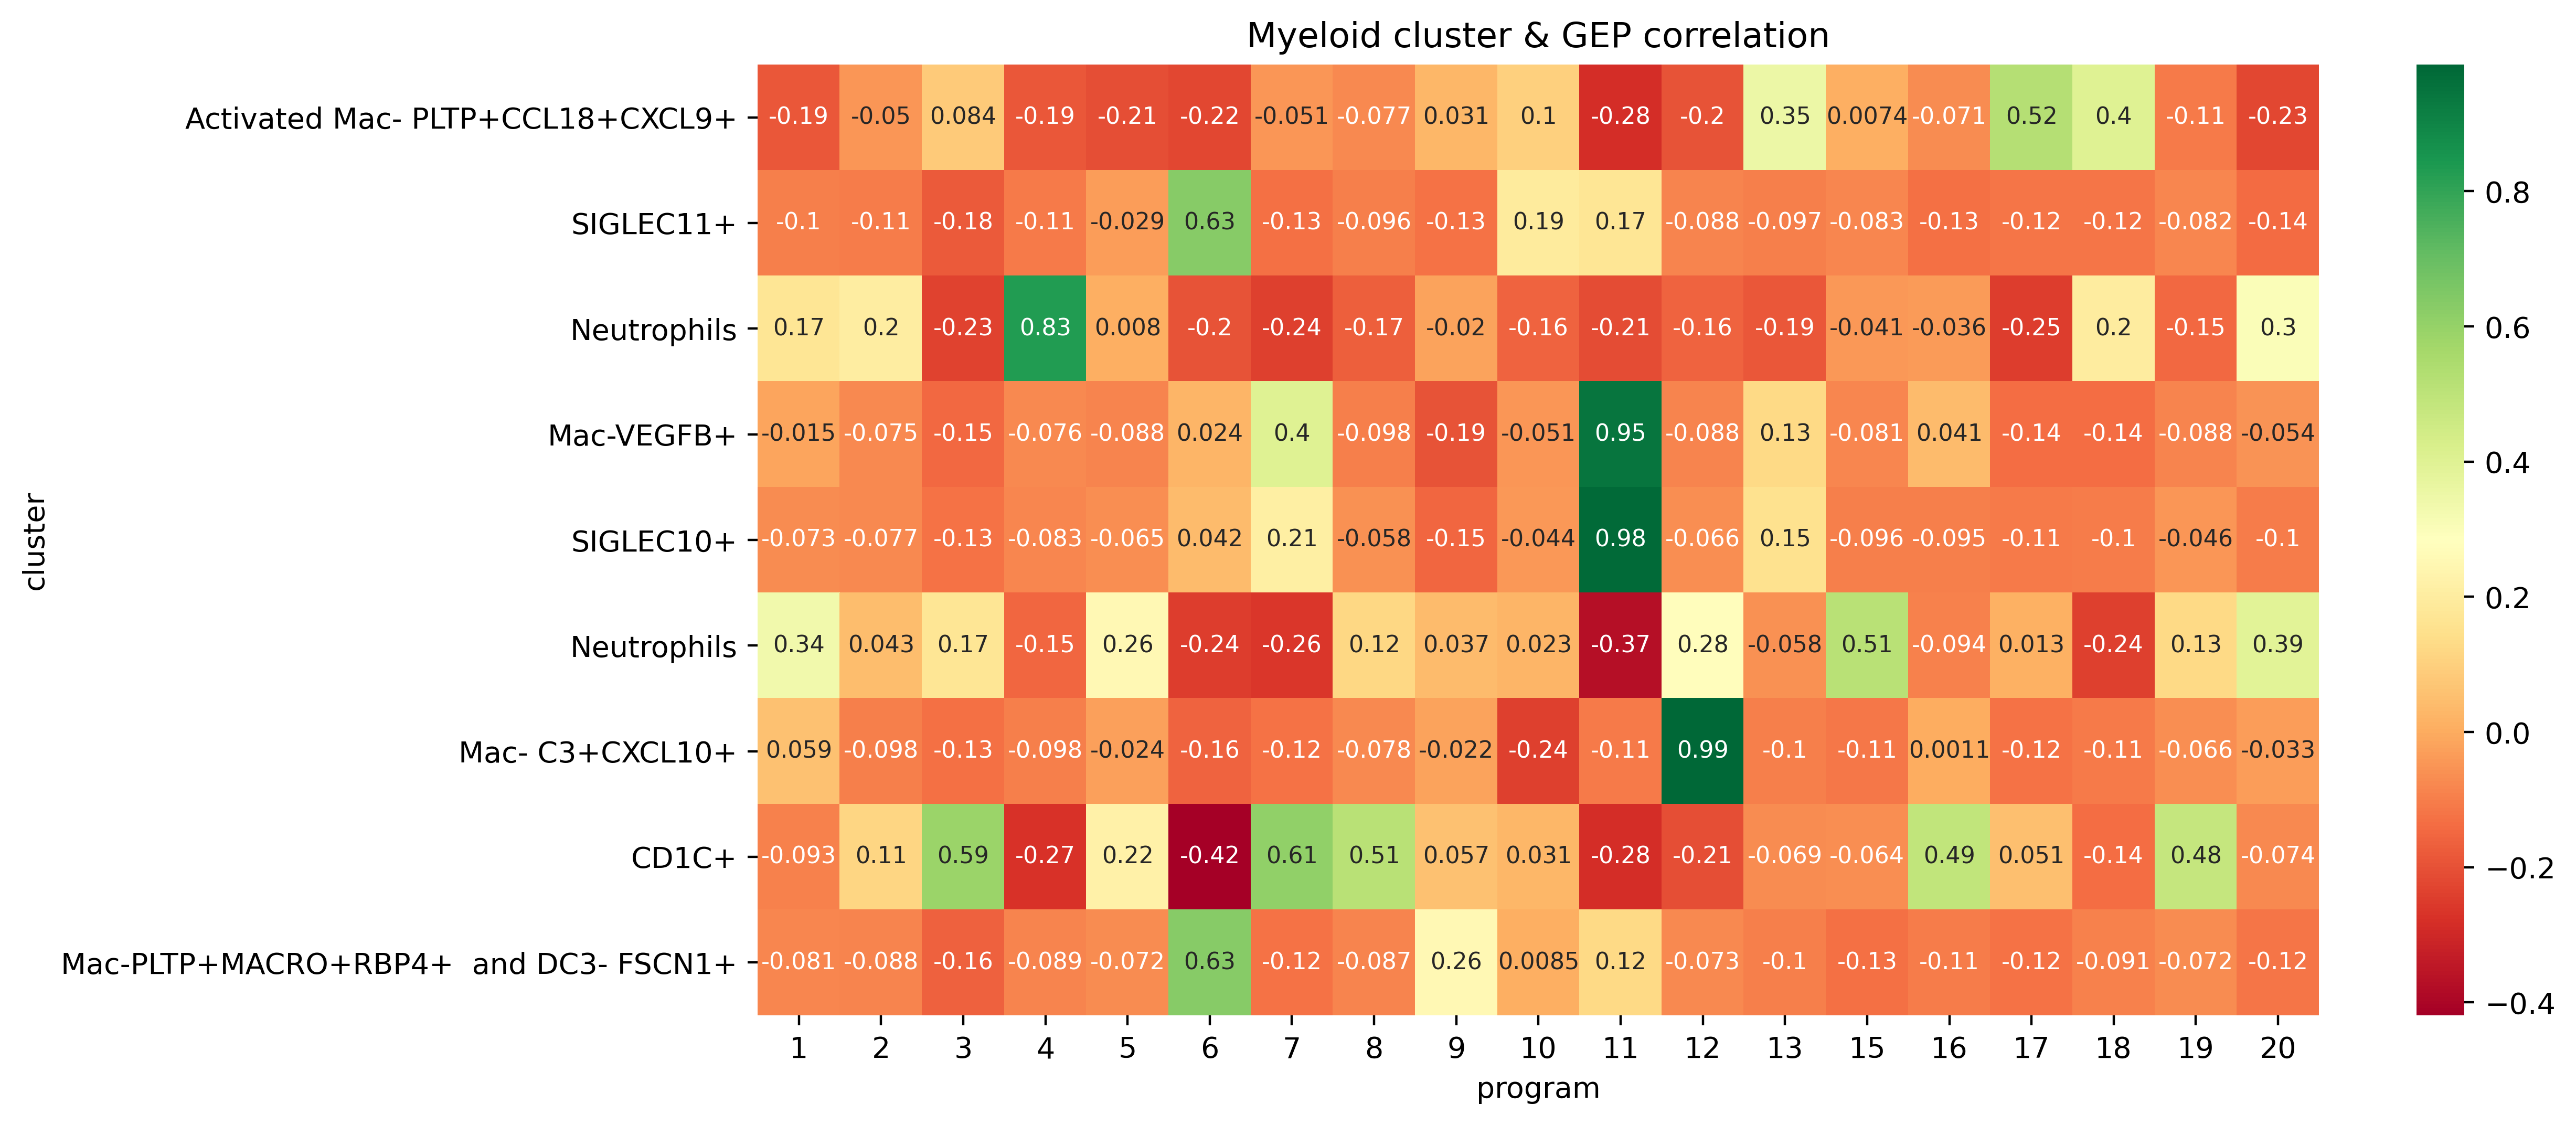

In [74]:
corr_matrix = np.corrcoef(mye_cluster_fraction_df, GEP_fraction_df, rowvar=False)[:mye_cluster_fraction_df.shape[1],-GEP_fraction_df.shape[1]:]

plt.figure(figsize=(12,6))
# sns. set(font_scale=1) 
g=sns.heatmap(corr_matrix,annot=True,cmap="RdYlGn",  annot_kws={"fontsize":8}, 
              yticklabels=myeloid_ann.annotation,#range(1,mye_cluster_fraction_df.shape[1]+1),
             xticklabels=GEP_fraction_df.columns.tolist()).set(xlabel='program', ylabel='cluster', title='Myeloid cluster & GEP correlation')



CD8 clustering:

In [75]:
CD8_annotation_path = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/subcohort_1.1.22/17.1.22/CD8.xlsx'
CD8_CLUSTER_BARCODE_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/subcohort_1.1.22_run_1.1.22/subcohort_CD8_1.1.22_clusters_mapping.csv'


CD8_ann = pd.read_excel(CD8_annotation_path).set_index('cluster')
CD8_clusters_barcodes_mapping_df = pd.read_csv(CD8_CLUSTER_BARCODE_MAPPING_PATH)[['Sample', 'Barcode', 'Cluster']]

CD8_cluster_fraction_df = get_cluster_fraction_df(CD8_clusters_barcodes_mapping_df)
### reform cluster_fraction_df
CD8_cluster_fraction_df = CD8_cluster_fraction_df.pivot(index='sample', columns='cluster')
CD8_cluster_fraction_df.columns = CD8_cluster_fraction_df.columns.droplevel(0)

immune clustering:

In [76]:
immune_annotation_path = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/subcohort_1.1.22/17.1.22/immune.xlsx'
IMMUNE_CLUSTER_BARCODE_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/subcohort_1.1.22_run_1.1.22/subcohort_immune_1.1.22_clusters_mapping.csv'

immune_ann = pd.read_excel(immune_annotation_path).set_index('CLUSTER_IDX').rename(columns={'annotations':'annotation'})
immune_clusters_barcodes_mapping_df = pd.read_csv(IMMUNE_CLUSTER_BARCODE_MAPPING_PATH)[['Sample', 'Barcode', 'Cluster']]

immune_cluster_fraction_df = get_cluster_fraction_df(immune_clusters_barcodes_mapping_df)
### reform cluster_fraction_df
immune_cluster_fraction_df = immune_cluster_fraction_df.pivot(index='sample', columns='cluster')
immune_cluster_fraction_df.columns = immune_cluster_fraction_df.columns.droplevel(0)
# immune_cluster_fraction_df

In [77]:
# groups_dic = {'immune': [immune_cluster_fraction_df, immune_ann.annotations], 'CD8':[CD8_cluster_fraction_df, CD8_ann.annotation], 'myeloid':[mye_cluster_fraction_df, myeloid_ann.annotation], 'GEP':[GEP_fraction_df, GEP_fraction_df.columns.tolist()]}
groups_dic = {'immune': [immune_cluster_fraction_df, immune_ann],
              'CD8':[CD8_cluster_fraction_df, CD8_ann], 
              'myeloid':[mye_cluster_fraction_df, myeloid_ann], 
              'GEP':[GEP_fraction_df, pd.DataFrame(GEP_fraction_df.columns.tolist(), columns=['annotation'], index=GEP_fraction_df.columns.tolist())]}
from itertools import combinations
group_pairs = list(combinations(groups_dic.keys(), 2))

In [78]:
# immune_cluster_fraction_df.columns
# group_A_ann
# myeloid_ann.set_index('cluster')


Correlations of all pairs:

In [86]:
fig, axs = plt.subplots(3, 2)
axs = axs.ravel()
fig.set_size_inches(26, 40)

summary_corr_df = pd.DataFrame(columns=['GROUP_A', 'GROUP_B', 'cluster_A',  'cluster_B', 'cluster_A_ann', 'cluster_B_ann', 'corr', 'pval'])

for i in range(len(group_pairs)):
    group_A_name = group_pairs[i][0]
    group_B_name = group_pairs[i][1]
    
    group_A_fraction_df = groups_dic[group_A_name][0]
    group_B_fraction_df = groups_dic[group_B_name][0]
    
    group_A_ann = groups_dic[group_A_name][1]
    group_B_ann = groups_dic[group_B_name][1]
    
    ##### Update df - add row for each pair of clusters/GEP correlation and pval
    for cluster_i in group_A_fraction_df.columns.tolist():
#         print(group_B_fraction_df.columns.tolist())
        for cluster_j in group_B_fraction_df.columns.tolist():        
            corr, pval = scipy.stats.pearsonr(group_A_fraction_df[cluster_i], group_B_fraction_df[cluster_j])
#             print([[cluster_j-1, group_B_name, cluster_j]])
#             print(group_B_ann.loc[cluster_j].annotation)
            summary_corr_df = summary_corr_df.append(pd.DataFrame([[group_A_name, group_B_name, cluster_i, cluster_j, group_A_ann.loc[cluster_i].annotation, group_B_ann.loc[cluster_j].annotation, corr, pval]], 
                                                     columns=summary_corr_df.columns))
        
        
    ##### Draw heatmaps
    corr_matrix = np.corrcoef(group_A_fraction_df, group_B_fraction_df, rowvar=False)[:group_A_fraction_df.shape[1],-group_B_fraction_df.shape[1]:]

    g=sns.heatmap(corr_matrix,annot=True,cmap="RdYlGn",
                  annot_kws={"fontsize":8},
                  ax=axs[i],
                  yticklabels=group_A_ann.annotation,
                 xticklabels=group_B_ann.annotation).set(xlabel=group_B_name, ylabel=group_A_name, title=f'{group_A_name} & {group_B_name} correlation')
fig.tight_layout()
summary_corr_df = summary_corr_df.reset_index().drop(columns=['index'])

In [90]:
pd.set_option('display.max_rows', 10)

summary_corr_df[summary_corr_df.pval<0.05].sort_values('pval').reset_index(drop=True)
# summary_corr_df.sort_values('pval').reset_index(drop=True)

GROUP_A  GROUP_B cluster_A cluster_B       cluster_A_ann  \
0   myeloid      GEP         7        12     Mac- C3+CXCL10+   
1   myeloid      GEP         5        11           SIGLEC10+   
2    immune      GEP         2         4   Exhausted T cells   
3   myeloid      GEP         4        11          Mac-VEGFB+   
4    immune      CD8         5         5   Exhausted T cells   
..      ...      ...       ...       ...                 ...   
49   immune  myeloid         1         5            Myeloids   
50  myeloid      GEP         8        19               CD1C+   
51   immune      GEP        10        20            NK cells   
52   immune  myeloid         3         2  NK cells\NKT cells   
53   immune  myeloid         1         1            Myeloids   

                                        cluster_B_ann      corr          pval  
0                                                  12  0.987379  3.111152e-14  
1                                                  11  0.979154  1.679998e-12  
2                                                   4  0.967659  5.437772e-11  
3                                                  11  0.947344  2.517706e-09  
4   CXCL13+HLA-DQA2+HAVCR2+- Tissue resident memeo...  0.941396  5.815499e-09  
..                                                ...       ...           ...  
49                                          SIGLEC10+  0.487609  4.010480e-02  
50                                                 19  0.477794  4.492162e-02  
51                                                 20  0.476660  4.550497e-02  
52                                          SIGLEC11+  0.473921  4.693881e-02  
53                   Activated Mac- PLTP+CCL18+CXCL9+ -0.468961  4.962153e-02  

[54 rows x 8 columns]

In [91]:
pd.set_option('display.max_rows', 10)

summary_corr_df[summary_corr_df.pval<0.05].sort_values('pval').reset_index(drop=True).to_excel(r'/storage/md_keren/shitay/garbage/c.xlsx')

### 3. CNV patterns, let's see whether we can see (by eye) some differences between Cutaneous/Mucosal samples' CNV patterns.

### 4. remove GEP #14

Extract GEP table from server:

In [8]:
melanoma_clinical_data = get_constant_cohort(3) #get_clinical_data(71)#ICI=True, after_biopsy='ICI')
# melanoma_clinical_data

GEP_DF, R_GEP_DF, NR_GEP_DF = get_GEP_dfs(melanoma_clinical_data, EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/subcohort_1.1.22',
                    RUN_RANGE = '20', selected_K=20, number_of_genes=2000, n_replicates=200, local_density_threshold='0.10', FEATURE='response', FEATURE_A='R', FEATURE_B='NR')
# GEP_fraction_df = get_GEP_fraction_df(GEP_DF)

# ### reform GEP_fraction_df
# GEP_fraction_df = GEP_fraction_df.pivot(index='sample', columns='program')
# GEP_fraction_df.columns = GEP_fraction_df.columns.droplevel(0)
# GEP_fraction_df

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_12.21_unportected.csv

and labels:
/storage/md_keren/shitay/Data/tables/clinical_labels.csv


Check what percentage of the cells would be removed with different values of association usage threshold:

In [9]:
reduced_GEP_DF = GEP_DF.iloc[:, [0, 1,2,3,17]]
print(f'{len(reduced_GEP_DF)} cells')
d2 = sort_dic({k:v/len(reduced_GEP_DF) for k,v in dict(Counter(round(reduced_GEP_DF[14],1))).items()})
d3 = {}
acuu_val = 0
for k,v in d2.items():
    acuu_val += v
#     print(acuu_val)
    d3[k] = acuu_val
sort_dic(d3)

51401 cells


{0.0: 0.9032898192642167,
 0.1: 0.9642419408182721,
 0.2: 0.9783272698974729,
 0.3: 0.9849613820742787,
 0.4: 0.9889690862045486,
 0.5: 0.9923931441022549,
 0.6: 0.9949806423999533,
 0.7: 0.9966732164743877,
 0.8: 0.9981712418046341,
 0.9: 0.9997859963813933,
 1.0: 1.0}

Check amount of the cells would be removed with different values of association usage threshold:

In [10]:
d2 = sort_dic(dict(Counter(round(reduced_GEP_DF[14],1))), True, True)
d3 = {}
acuu_val = 0
for k,v in d2.items():
    acuu_val += v
#     print(acuu_val)
    d3[k] = acuu_val
sort_dic(d3)

{0.0: 51401,
 0.1: 4971,
 0.2: 1838,
 0.3: 1114,
 0.4: 773,
 0.5: 567,
 0.6: 391,
 0.7: 258,
 0.8: 171,
 0.9: 94,
 1.0: 11}

### 4.1. Filter out contaminated cells, cells with GEP #14 usage > 0.1, store these cells in a df and then create a cohort clean of those cells:

In [11]:
selected_threshold = 0.1
print(f'{sum(reduced_GEP_DF[14]>=selected_threshold)} cells will be removed')
contaminated_cells = reduced_GEP_DF[reduced_GEP_DF[14]>=selected_threshold]
contaminated_cells.head()

2659 cells will be removed


sample             barcode response  associated program        14
8     M106  AAAGATGCATGAAGTA-1       NR                  14  0.357107
36    M106  AAATGCCGTCAAAGAT-1       NR                  17  0.120687
61    M106  AACGTTGGTACGCTGC-1       NR                  17  0.107203
71    M106  AACTCCCAGAAAGTGG-1       NR                  17  0.134576
101   M106  AAGACCTCACGGCCAT-1       NR                  15  0.193427

In [13]:
contaminated_cells.to_csv(r'/storage/md_keren/shitay/Data/tables/GEP/contaminated_cells_list/subcohort_1.1.22_GEP14_contaminated_cells.csv')

### 4.2. Create new cohort 
A new version of the cohort identical to the previous version (from 1.1.22) except of contaminated cells (GEP #14 cells) that will not be there.

cohort -

* /storage/md_keren/shitay/Data/droplet_seq/M97_M173/subcohort/non_normalized
* /storage/md_keren/shitay/Data/droplet_seq/M97_M173/subcohort/normalized
* all files from 4.11.21, will be updated to 16.3.22

subcohort -

* /storage/md_keren/shitay/Data/droplet_seq/M97_M173/subcohort/non_normalized
* /storage/md_keren/shitay/Data/droplet_seq/M97_M173/subcohort/normalized
* all files from 1.1.22, will be updated to 16.3.22

In [6]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/subcohort/normalized/1.1.22/subcohort_normalized_1.1.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))

filter cohort from contaminated cells. Go through all cohort files and in each of them filter out contaminated cells:

In [56]:
DATA_ROOT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173'
COHORT_NAMES = ['cohort', 'subcohort']
NORMALIZATION_MODES = ['non_normalized', 'normalized']

for cohort_name in COHORT_NAMES:
    for nor_mode in NORMALIZATION_MODES:
        curr_base_folder = join(DATA_ROOT_PATH, cohort_name, nor_mode)
        if '4.11.21' in os.listdir(curr_base_folder):
            existing_pkls_folder = join(curr_base_folder, '4.11.21')
        elif '1.1.22' in os.listdir(curr_base_folder):
            existing_pkls_folder = join(curr_base_folder, '1.1.22')
        else:
            print('ERROR!')
        dest_folder = join(curr_base_folder, '16.3.22')
        
        print(existing_pkls_folder)
        print(dest_folder)
        create_folder(dest_folder)
        print('pkl files:')
        for pkl_file_name in os.listdir(existing_pkls_folder):
            if 'immune' in pkl_file_name:
                continue
            pkl_file_path = join(existing_pkls_folder, pkl_file_name)
            dest_file_path = join(dest_folder, pkl_file_name)
            print(f'source {pkl_file_path}')
            print(f'dest {dest_file_path}')
            
            curr_cohort = pickle.load(open(pkl_file_path, 'rb'))
            filtered_cohort = curr_cohort.filter_cohort_from(contaminated_cells['sample'], contaminated_cells['barcode'])
            pickle.dump((filtered_cohort), open(dest_file_path, 'wb'), protocol=4)

        print(end='\n\n')

/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/non_normalized/4.11.21
/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/non_normalized/16.3.22
pkl files:
source /storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/non_normalized/4.11.21/cohort_non_normalized_4.11.21.pkl
dest /storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/non_normalized/16.3.22/cohort_non_normalized_4.11.21.pkl


/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/4.11.21
/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/16.3.22
pkl files:
source /storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/4.11.21/cohort_normalized_4.11.21.pkl
dest /storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/16.3.22/cohort_normalized_4.11.21.pkl
source /storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/4.11.21/cohort_normalized_4.11.21_protein_coding_genes.pkl
dest /storage/md_keren/shitay/Data/droplet_seq/M97_M173/c

# DEBUG

In [13]:
melanoma_clinical_data.sort_values(["Melanoma type", "response"])

Patient id Melanoma type response prior to biopsy   after biopsy   ICI  \
1        M106     Cutaneous       NR             ICI  other therapy  True   
2        M107     Cutaneous       NR             ICI  other therapy  True   
4        M120     Cutaneous       NR             ICI  other therapy  True   
10       M141     Cutaneous       NR             ICI  other therapy  True   
11       M145     Cutaneous       NR             ICI            ICI  True   
12       M146     Cutaneous       NR             ICI            ICI  True   
14       M151     Cutaneous       NR             ICI  other therapy  True   
15       M153     Cutaneous       NR         nothing            ICI  True   
16       M161     Cutaneous       NR             ICI            ICI  True   
6        M130     Cutaneous        R   other therapy            ICI  True   
7        M131     Cutaneous        R             ICI  other therapy  True   
9        M137     Cutaneous        R             ICI  other therapy  True   
13       M147     Cutaneous        R         nothing            ICI  True   
17       M162     Cutaneous        R   other therapy            ICI  True   
0         M99       Mucosal       NR             ICI  other therapy  True   
3        M111       Mucosal       NR             ICI  other therapy  True   
5        M128       Mucosal       NR   other therapy            ICI  True   
8        M136       Mucosal       NR             ICI  other therapy  True   

     BRAF  
1   False  
2   False  
4    True  
10   True  
11   True  
12   True  
14  False  
15   True  
16  False  
6   False  
7   False  
9    True  
13  False  
17   True  
0   False  
3   False  
5   False  
8   False

In [4]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/subcohort/normalized/16.3.22/sub_cohort_tumor_cells_normalized_1.1.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))

In [11]:
set(GEP_DF['sample'])

{'M106',
 'M107',
 'M111',
 'M120',
 'M128',
 'M130',
 'M131',
 'M136',
 'M137',
 'M141',
 'M145',
 'M146',
 'M147',
 'M151',
 'M153',
 'M161',
 'M162',
 'M99'}

In [2]:
melanoma_clinical_data = get_constant_cohort(3) #get_clinical_data(71)#ICI=True, after_biopsy='ICI')
# melanoma_clinical_data

GEP_DF, R_GEP_DF, NR_GEP_DF = get_GEP_dfs(melanoma_clinical_data, EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/subcohort_1.1.22',
                    RUN_RANGE = '20', selected_K=20, number_of_genes=2000, n_replicates=200, local_density_threshold='0.10', FEATURE='response', FEATURE_A='R', FEATURE_B='NR')
GEP_fraction_df = get_GEP_fraction_df(GEP_DF)

### reform GEP_fraction_df
GEP_fraction_df = GEP_fraction_df.pivot(index='sample', columns='program')
GEP_fraction_df.columns = GEP_fraction_df.columns.droplevel(0)

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_12.21_unportected.csv

and labels:
/storage/md_keren/shitay/Data/tables/clinical_labels.csv


In [36]:
# GEP_DF.drop(columns=[14])
contaminated_cells = pd.read_csv(r'/storage/md_keren/shitay/Data/tables/GEP/subcohort_1.1.22/contaminated_cells_list/GEP14_contaminated_cells.csv')[['sample', 'barcode']]
contaminated_cells
GEP_DF.drop(columns=[14])[['sample', 'barcode']]
contaminated_cells_identifiers = [tuple(aa) for aa in contaminated_cells.values.tolist()]
GEP_identifiers = [tuple(aa) for aa in GEP_DF.drop(columns=[14])[['sample', 'barcode']].values.tolist()]

In [45]:
contaminated_indexes = [aa in contaminated_cells_identifiers for aa in GEP_identifiers]

In [6]:
# GEP_DF[~np.array(contaminated_indexes)].drop(columns=[14])

In [3]:
ddd = filter_contaminated_cells_out_of_GEP_DF(GEP_DF, 14, contaminated_cells_path = r'/storage/md_keren/shitay/Data/tables/GEP/subcohort_1.1.22/contaminated_cells_list/GEP14_contaminated_cells.csv')

In [7]:
ddd
# GEP_DF

sample             barcode response  associated program         1  \
0       M106  AAACCTGAGATCCCAT-1       NR                  15  0.000000   
1       M106  AAACCTGCACTAAGTC-1       NR                  17  0.009477   
2       M106  AAACCTGGTTGTCTTT-1       NR                  15  0.004528   
3       M106  AAACCTGTCATGCATG-1       NR                  17  0.000000   
4       M106  AAACCTGTCGTATCAG-1       NR                  17  0.000000   
...      ...                 ...      ...                 ...       ...   
51395   M162  TTTGTCATCAAGGTAA-1        R                  12  0.000248   
51396   M162  TTTGTCATCCCAAGTA-1        R                  12  0.000000   
51397   M162  TTTGTCATCCTTAATC-1        R                  12  0.000000   
51398   M162  TTTGTCATCGGTTAAC-1        R                  12  0.000000   
51399   M162  TTTGTCATCTGGTGTA-1        R                  12  0.000000   

              2         3         4         5         6  ...        10  \
0      0.037515  0.000000  0.065667  0.023132  0.089895  ...  0.056826   
1      0.107657  0.073435  0.000000  0.000000  0.000000  ...  0.000000   
2      0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
3      0.024897  0.000000  0.026137  0.000000  0.027071  ...  0.000000   
4      0.000000  0.000000  0.210960  0.000000  0.000000  ...  0.000000   
...         ...       ...       ...       ...       ...  ...       ...   
51395  0.004144  0.000000  0.066740  0.014147  0.113919  ...  0.000000   
51396  0.101531  0.000000  0.000000  0.000000  0.027136  ...  0.038199   
51397  0.021792  0.000000  0.055639  0.000000  0.006368  ...  0.000000   
51398  0.091065  0.005419  0.000000  0.000000  0.000000  ...  0.244660   
51399  0.098982  0.000000  0.015309  0.016849  0.107863  ...  0.000000   

             11        12        13        15        16        17        18  \
0      0.000000  0.000000  0.000000  0.505320  0.027660  0.141579  0.000000   
1      0.000000  0.000000  0.020131  0.109511  0.000000  0.608337  0.000000   
2      0.000000  0.000000  0.000000  0.980855  0.014618  0.000000  0.000000   
3      0.003841  0.043620  0.077365  0.305714  0.000000  0.456966  0.000000   
4      0.003915  0.210589  0.000000  0.152869  0.000000  0.218759  0.130728   
...         ...       ...       ...       ...       ...       ...       ...   
51395  0.014824  0.708113  0.049590  0.003637  0.000000  0.000000  0.024638   
51396  0.009071  0.639291  0.053474  0.000000  0.000000  0.053217  0.019099   
51397  0.004134  0.693987  0.123319  0.003299  0.067606  0.000000  0.000000   
51398  0.000000  0.528580  0.000000  0.000000  0.000000  0.091131  0.000000   
51399  0.000000  0.679749  0.081248  0.000000  0.000000  0.000000  0.000000   

             19       20  
0      0.000000  0.00000  
1      0.069581  0.00000  
2      0.000000  0.00000  
3      0.000000  0.00000  
4      0.000000  0.04636  
...         ...      ...  
51395  0.000000  0.00000  
51396  0.049836  0.00000  
51397  0.000000  0.00000  
51398  0.005981  0.00000  
51399  0.000000  0.00000  

[48742 rows x 23 columns]

In [ ]:
filtered_cohort = cohort.get_filtered_subset_by_identifiers(contaminated_cells['sample'], contaminated_cells['barcode'])
print(filtered_cohort.number_of_cells)
print(len([g for g in zip(contaminated_cells['sample'], contaminated_cells['barcode']) if g in list((zip(cohort.samples, cohort.barcodes)))]))
# len([g for g in contaminated_cells['barcode'] if g in filtered_cohort.barcodes])
print(len([g for g in zip(contaminated_cells['sample'], contaminated_cells['barcode']) if g in list((zip(filtered_cohort.samples, filtered_cohort.barcodes)))]))

In [ ]:
#### Merge DFs:
# GEP_clusters_merged_df = pd.merge(cluster_fraction_df.rename(columns={'sample_fraction':'cluster_sample_fraction'}), GEP_fraction_df.rename(columns={'sample_fraction':'GEP_sample_fraction'}),on='sample')
# GEP_clusters_merged_df

# current_GEP_cluster_df = GEP_clusters_merged_df[(GEP_clusters_merged_df['cluster']==5) & (GEP_clusters_merged_df['program']==7)]
# # current_GEP_cluster_df.cluster_sample_fraction #GEP_sample_fraction

In [ ]:
n_cells_in_sample_df = GEP_DF.groupby(['sample']).count().reset_index()[['sample', 'barcode']].rename(columns={'barcode': 'count'}).set_index('sample')
n_cells_in_GEP_df = GEP_DF.groupby(['sample', 'associated program']).count().reset_index()[['sample', 'associated program', 'barcode']].rename(columns={'associated program': 'program', 'barcode': 'count'})

n_cells_in_GEP_df['n_cells_in_sample'] = n_cells_in_GEP_df['sample'].apply(lambda x: n_cells_in_sample_df.loc[x]['count'])
n_cells_in_GEP_df['sample_fraction'] = n_cells_in_GEP_df['count'] / n_cells_in_GEP_df['n_cells_in_sample']
GEP_fraction_df = n_cells_in_GEP_df[['sample', 'program', 'sample_fraction']]

#### Add sample & cluster pairs which do not appear in fraction_df
sample_program_pairs = [[sam, cl] for sam in GEP_DF['sample'].unique().tolist() for cl in GEP_DF['associated program'].unique().tolist()]
zero_fraction_pairs_df = pd.DataFrame([[pair[0],pair[1],0]   for pair in sample_cluster_pairs if not pair in GEP_fraction_df[['sample', 'program']].values.tolist()], columns=['sample', 'program', 'sample_fraction'])
GEP_fraction_df = GEP_fraction_df.append(zero_fraction_pairs_df).sort_values(['sample', 'program']).reset_index().drop(columns=('index'))
GEP_fraction_df

##################### clustering #####################
myeloid_annotation_path = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/subcohort_1.1.22/17.1.22/Myeloid.xlsx'
MYELOID_CLUSTER_BARCODE_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/subcohort_1.1.22_run_1.1.22/subcohort_myeloid_1.1.22_clusters_mapping.csv'
# COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/subcohort/normalized/1.1.22/subcohort_normalized_1.1.22_protein_coding_genes.pkl'


MYELOID_CLUSTER_BARCODE_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/subcohort_1.1.22_run_1.1.22/subcohort_myeloid_1.1.22_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(MYELOID_CLUSTER_BARCODE_MAPPING_PATH)[['Sample', 'Barcode', 'Cluster']]
myeloid_ann = pd.read_excel(myeloid_annotation_path)


n_cells_in_cluster_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().rename(columns={'Sample':'sample', 'Cluster':'cluster', 'Barcode': 'n_cells_in_cluster'})
n_cells_in_sample_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().rename(columns={'Sample':'sample', 'Cluster':'cluster', 'Barcode': 'n_cells_in_sample'}).iloc[:, :2].set_index('sample')
n_cells_in_cluster_df['n_cells_in_sample'] = n_cells_in_cluster_df['sample'].apply(lambda x: n_cells_in_sample_df.loc[x]['n_cells_in_sample'])

n_cells_in_cluster_df['sample_fraction'] = n_cells_in_cluster_df['n_cells_in_cluster'] / n_cells_in_cluster_df['n_cells_in_sample'] 
cluster_fraction_df = n_cells_in_cluster_df[['sample', 'cluster', 'sample_fraction']]

#### Add sample & cluster pairs which do not appear in fraction_df
sample_cluster_pairs = [[sam, cl] for sam in clusters_barcodes_mapping_df['Sample'].unique().tolist() for cl in clusters_barcodes_mapping_df['Cluster'].unique().tolist()]
zero_fraction_pairs_df = pd.DataFrame([[pair[0],pair[1],0]   for pair in sample_cluster_pairs if not pair in cluster_fraction_df[['sample', 'cluster']].values.tolist()], columns=['sample', 'cluster', 'sample_fraction'])
cluster_fraction_df = cluster_fraction_df.append(zero_fraction_pairs_df).sort_values(['sample', 'cluster']).reset_index().drop(columns=('index'))

cluster_fraction_df

In [2]:
def get_GEP_dfs(res_melanoma_clinical_data):
    RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
    USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

    usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
    usage_matrix.columns = np.arange(1, selected_K + 1)
    normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
    samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
    df = normalized_usage_matrix.copy()
    df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
    df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
    # keep only data of current patients in cohort
    GEP_all_samples_df = df.copy()
    df = df[df['sample'].isin(res_melanoma_clinical_data.index.tolist())]

    df[FEATURE] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x][FEATURE])


    df_r = df[df[FEATURE] == FEATURE_A]
    df_nr = df[df[FEATURE] == FEATURE_B]
    ##### Assign each cell one program based on the maximal usage value.
    r_high_prog = np.argmax(df_r[list(range(1, N_PROG + 1))].values, axis=1) + 1
    nr_high_prog = np.argmax(df_nr[list(range(1, N_PROG + 1))].values, axis=1) + 1

    df_r.loc[:, 'associated program'] = r_high_prog
    df_nr.loc[:, 'associated program'] = nr_high_prog
    return df, df_r, df_nr

In [13]:

lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'#/conducting_statistical_tests_in_clustering_and_GEP'

sys.path.append(lib)

# from scripts.conducting_statistical_tests_in_clustering_and_GEP import *
# from classifying_response_to_immunotherapy.utilities.factory_cfg import *
from utilities.unsupervised_data_properties import *
get_GEP_dfs
melanoma_clinical_data = get_constant_cohort(3) #get_clinical_data(71)#ICI=True, after_biopsy='ICI')
# melanoma_clinical_data
import warnings 
warnings.filterwarnings("ignore")

df, df_r, df_nr = get_GEP_dfs(melanoma_clinical_data, EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/subcohort_1.1.22',
                    RUN_RANGE = '20', selected_K=20, number_of_genes=2000, n_replicates=200, local_density_threshold='0.10', FEATURE='response', FEATURE_A='R', FEATURE_B='NR')

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_12.21_unportected.csv

and labels:
/storage/md_keren/shitay/Data/tables/clinical_labels.csv


In [ ]:
df.reset_index()[df.columns[-3:].tolist()+df.columns[:-3].tolist()]


In [ ]:
# np.corrcoef(mye_cluster_fraction_df, GEP_fraction_df, rowvar=False).shape#[:mye_cluster_fraction_df.shape[1],-GEP_fraction_df.shape[1]:]
# scipy.stats.pearsonr(mye_cluster_fraction_df, GEP_fraction_df)
# GEP_fraction_df[1]

# mye_cluster_fraction_df.columns.tolist()
# summary_corr_df = pd.DataFrame(columns=['GROUP_A', 'GROUP_B', 'cluster_A',  'cluster_B', 'cluster_A_ann', 'cluster_B_ann', 'corr', 'pval'])
# summary_corr_df

# for cluster_i in mye_cluster_fraction_df.columns.tolist():
#     for cluster_j in mye_cluster_fraction_df.columns.tolist():        
#         corr, pval = scipy.stats.pearsonr(mye_cluster_fraction_df[cluster_i], GEP_fraction_df[cluster_j])
#         summary_corr_df = summary_corr_df.append(pd.DataFrame([['MYE', 'MYE', cluster_i, cluster_j, 'ann_a', 'ann_b', corr, pval]], 
#                                                  columns=summary_corr_df.columns))
# summary_corr_df

In [ ]:
# annotation paths
immune_annotation_path = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/subcohort_1.1.22/17.1.22/immune.xlsx'
myeloid_annotation_path = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/subcohort_1.1.22/17.1.22/Myeloid.xlsx'
CD8_annotation_path = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/subcohort_1.1.22/17.1.22/CD8.xlsx'
# GEP pathways path
GEP_pathways_path = r'/storage/md_keren/shitay/Data/tables/GEP/subcohort_1.1.22/k20_2000genes_200iter/GEPS_pathways.xlsx'



IMMUNE_CLUSTER_BARCODE_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/subcohort_1.1.22_run_1.1.22/subcohort_immune_1.1.22_clusters_mapping.csv'
CD8_CLUSTER_BARCODE_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/subcohort_1.1.22_run_1.1.22/subcohort_CD8_1.1.22_clusters_mapping.csv'
MYELOID_CLUSTER_BARCODE_MAPPING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/subcohort_1.1.22_run_1.1.22/subcohort_myeloid_1.1.22_clusters_mapping.csv'



######################## GEP Arguments ########################
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/subcohort_1.1.22'
selected_K = 20
local_density_threshold = '0.10'
number_of_genes = 2000
n_replicates = 200
RUN_RANGE = '20'
N_PROG = 20
NO_PATHWAYS_GEPS = [1]

ACTIVITY_GEP_CELL_USAGE_THRESHOLD = 0.1
ACTIVITY_GEP_SAMPLE_PORTION_THRESHOLD = 0.1


clusters_barcodes_mapping_df = pd.read_csv(IMMUNE_CLUSTER_BARCODE_MAPPING_PATH)

# immune_cohort=cohort.get_subset_by_identifiers(clusters_barcodes_mapping_df.Sample, clusters_barcodes_mapping_df.Barcode)